# Code Interpreter with magentic and GPT-4o

This example uses [magentic](https://github.com/jackmpcollins/magentic) to demonstrate using the [E2B Code Interpreter](https://github.com/e2b-dev/code-interpreter) as a tool with GPT-4o.

Two prompt-functions which can use the E2B Code Interpreter are defined: `plot_chart` and `update_chart`. These are used as follows:
- When the prompt-function is called, GPT-4o chooses to call the `execute_python` function, passing it the code to run.
- This is returned as a `FunctionCall` instance which we can validate before execution. In this case we just print out the code.
- Calling the `FunctionCall` instance invokes `execute_python` with the provided code, which executes the code using the E2B Code Interpreter and returns the result.

See the magentic docs for more details on prompt-functions and function calling: https://magentic.dev/

In [ ]:
%pip install magentic e2b_code_interpreter

In [1]:
# Read API keys from .env file or from environment variables

import os
from dotenv import load_dotenv

load_dotenv()

# TODO: Get your OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")

In [2]:
# Create the execute_python tool for using the E2B code interpreter
# including a docstring and parameter descriptions to help GPT understand the tool

from typing import Annotated

from e2b_code_interpreter import Execution
from e2b_code_interpreter import CodeInterpreter
from pydantic import Field


def execute_python(
    code: Annotated[
        str, Field(description="The python code to execute in a single cell.")
    ],
) -> Execution | None:
    """Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error."""
    with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
        print("Running code interpreter...")
        exec = code_interpreter.notebook.exec_cell(
            code,
            on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
            on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
            # You can also stream code execution results
            # on_result=...
        )
    if exec.error:
        print("[Code Interpreter ERROR]", exec.error)
    else:
        return exec

In [3]:
# Define the system prompt which will be resused between tasks

SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

```
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data representing the number of skyscrapers by city
data = {
    'City': ['New York', 'Hong Kong', 'Dubai', 'Shanghai', 'Chicago', 'Tokyo', 'Singapore', 'Toronto', 'Seoul', 'Sydney'],
    'Number of Skyscrapers': [284, 316, 148, 126, 126, 140, 94, 67, 82, 48]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Number of Skyscrapers', y='City', data=df, palette='viridis')
plt.title('Number of Skyscrapers by City')
plt.xlabel('Number of Skyscrapers')
plt.ylabel('City')
plt.show()
```
Running code interpreter...
[Code Interpreter] /tmp/ipykernel_780/3168240311.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Number of Skyscrapers', y='City', data=df, palette='viridis')



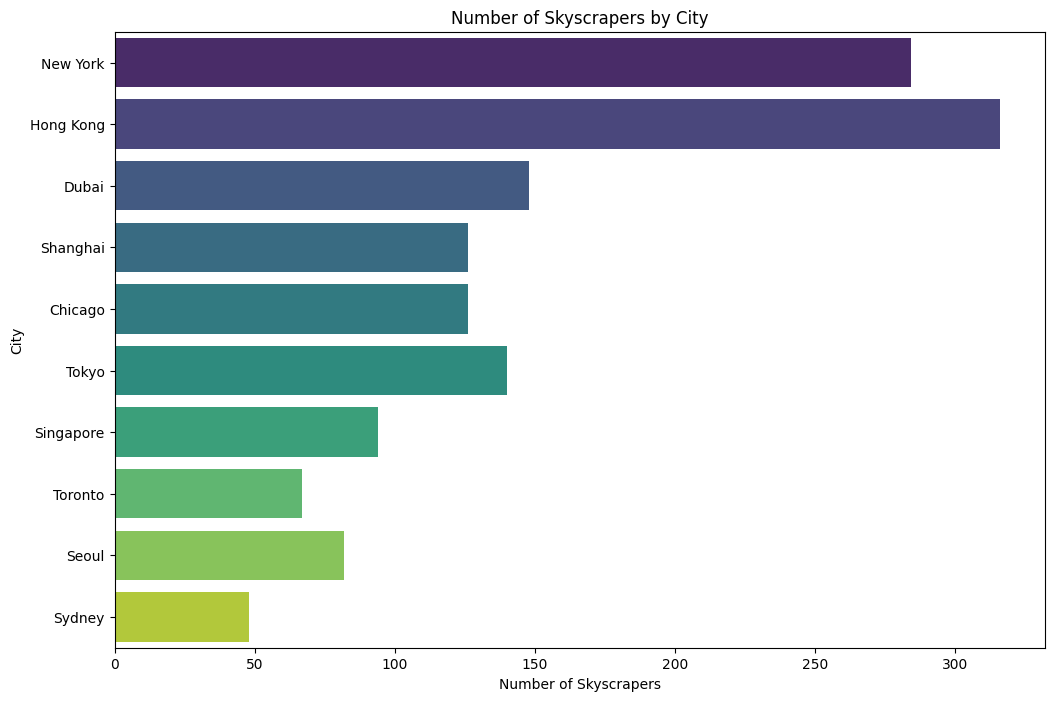

In [4]:
# Create a magentic prompt-function to plot a chart that uses the execute_python tool

from e2b_code_interpreter import Execution
from magentic import FunctionCall, chatprompt, SystemMessage, UserMessage, OpenaiChatModel


@chatprompt(
    SystemMessage(SYSTEM_PROMPT),
    UserMessage("Plot a chart to visualize: {query}"),
    functions=[execute_python],
    model=OpenaiChatModel("gpt-4o"),
)
def plot_chart(query: str) -> FunctionCall[Execution]: ...


function_call = plot_chart("number of skyscrapers by city")
print("```", function_call.arguments["code"], "```", sep="\n")

execution_plot_chart = function_call()
chart_result = execution_plot_chart.results[0]
chart_result

In [5]:
# Query GPT-4o to describe the image

from magentic import Placeholder
from magentic.vision import UserImageMessage


@chatprompt(
    UserMessage("Describe the image"),
    UserImageMessage(Placeholder(str, "image_url")),
    model=OpenaiChatModel("gpt-4o"),
)
def describe_image(image_url: str) -> str: ...


description = describe_image(image_url=f"data:image/png;base64,{chart_result.png}")
print(description)

The image is a horizontal bar chart titled "Number of Skyscrapers by City." It represents various cities along the y-axis and the number of skyscrapers in each city along the x-axis. The bars are differentiated by color, indicating the number of skyscrapers for each city. Below is the data represented:

1. **Hong Kong**: Approximately 315 skyscrapers (the highest among the listed cities)
2. **New York**: Approximately 250
3. **Dubai**: Approximately 150
4. **Shanghai**: Approximately 125
5. **Chicago**: Approximately 115
6. **Tokyo**: Approximately 105
7. **Singapore**: Approximately 85
8. **Toronto**: Approximately 65
9. **Seoul**: Approximately 50
10. **Sydney**: Approximately 35

The x-axis is labeled "Number of Skyscrapers," and the y-axis is labeled "City." The color gradient ranges from shades of green to blue to purple.


```
import matplotlib.pyplot as plt
import numpy as np

# Data
cities = ["New York", "Hong Kong", "Dubai", "Shanghai", "Chicago", "Tokyo", "Singapore", "Toronto", "Seoul", "Sydney",
            "Moscow", "London", "Paris", "Bangkok", "Kuala Lumpur", "Mumbai", "Jakarta", "Istanbul", "Frankfurt", "Melbourne"]
skyscrapers = [289, 355, 187, 156, 130, 172, 117, 108, 107, 98,
               90, 78, 68, 60, 54, 49, 44, 41, 39, 36]

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(cities, skyscrapers, color=plt.cm.viridis(np.linspace(0, 1, len(cities))))

# Add title and labels
ax.set_title('Number of Skyscrapers by City')
ax.set_xlabel('Number of Skyscrapers')
ax.set_ylabel('City')

# Add legend
ax.legend(['Skyscrapers per City'])

plt.show()
```
Running code interpreter...


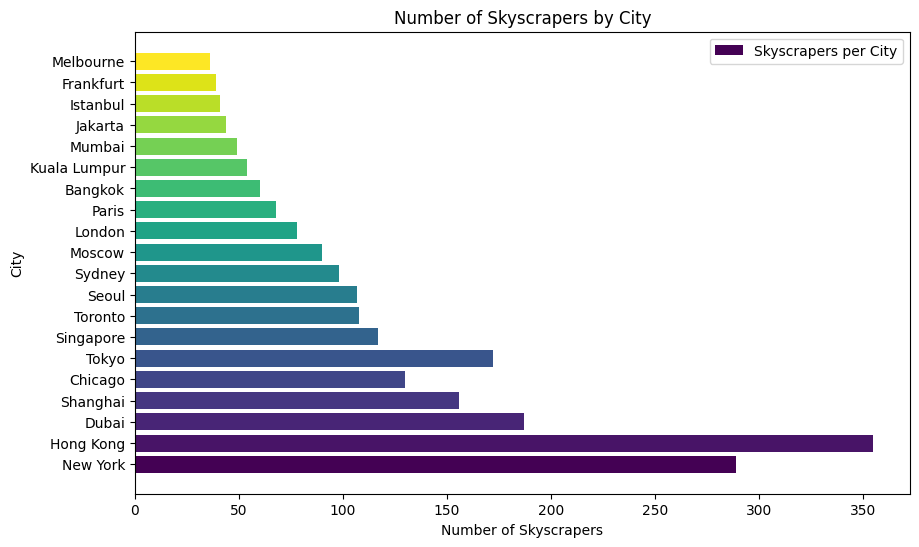

In [6]:
# Create another prompt-function to create an updated chart using the execute_python tool


@chatprompt(
    SystemMessage(SYSTEM_PROMPT),
    UserMessage("Update the following chart based on the instructions: {instructions}"),
    UserImageMessage(Placeholder(str, "image_url")),
    functions=[execute_python],
    model=OpenaiChatModel("gpt-4o", api_key=OPENAI_API_KEY),
)
def update_chart(instructions: str, image_url: str) -> FunctionCall[Execution]: ...


function_call = update_chart(
    "Add a legend and title to the chart, and add 10 more bars.",
    image_url=f"data:image/png;base64,{chart_result.png}",
)
print("```", function_call.arguments["code"], "```", sep="\n")

execution_update_chart = function_call()

# Display the results
for result in execution_update_chart.results:
    if result.png:
        display(result)
    elif result.text:
        print(result.text)